Sources used include the given article with its source code:
https://github.com/igul222/improved_wgan_training/blob/master/gan_cifar.py

Pytorch's GAN library https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py.

The DCGAN archtecture described in the article (source [22]):
https://github.com/indiradutta/DC_GAN/tree/main/dcgan


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd '/content/drive/MyDrive/Deep Learning/ex3__208144477_206556318'

/content/drive/MyDrive/Deep Learning/ex3__208144477_206556318


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools
import math

Data loading

In [4]:
def get_dataloaders(batch_size=128,trans='WGAN'):
    if trans == 'WGAN':
      transformation = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])

    if trans == 'DCGAN':
      transformation = transforms.Compose([transforms.ToTensor()])

    train_data = datasets.FashionMNIST('../fashion_data', train=True, download=True,transform=transformation)
    test_data = datasets.FashionMNIST('../fashion_data', train=False, download=True,transform=transformation)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

WGAN Generator

In [5]:
class WGAN_Generator(nn.Module):
    def __init__(self, img_size, latent_size, wngf):
      # wngf - depth of feature map in wgan generator

        super(WGAN_Generator, self).__init__()
        self.wngf = wngf
        self.latent_size = latent_size
        self.img_size = img_size
        self.feature_sizes = (2, 2)
        self.latent_size_change = nn.Sequential(nn.Linear(latent_size, int(8 * wngf * self.feature_sizes[0] * self.feature_sizes[1])),nn.ReLU())


        self.image_generation = nn.Sequential(

            nn.ConvTranspose2d(8 * wngf, 4 * wngf, 4, 2, 1),
            nn.BatchNorm2d(4 * wngf),
            nn.ReLU(),

            nn.ConvTranspose2d(4 * wngf, 2 * wngf, 4, 2, 1),
            nn.BatchNorm2d(2 * wngf),
            nn.ReLU(),

            nn.ConvTranspose2d(2 * wngf, wngf, 4, 2, 1),
            nn.BatchNorm2d(wngf),
            nn.ReLU(),

            nn.ConvTranspose2d(wngf, self.img_size[2], 4, 2, 1),
            nn.Sigmoid())


    def forward(self, input_data):
        x = self.latent_size_change(input_data)
        x = x.view(-1, int(8 * self.wngf), int(self.feature_sizes[0]), int(self.feature_sizes[1]))
        return self.image_generation(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_size))


DCGAN Generator

In [6]:
class DCGAN_Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=32):
      super(DCGAN_Generator, self).__init__()

      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh())


    def forward(self, input):
      output = self.network(input)
      return output

WGAN Discriminator

In [7]:
class WGAN_Discriminator(nn.Module):
    def __init__(self, img_size, wndf):
      # wndf - depth of feature map in wgan discriminator

        super(WGAN_Discriminator, self).__init__()
        self.img_size = img_size

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(self.img_size[2], wndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(wndf, 2 * wndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * wndf, 4 * wndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * wndf, 8 * wndf, 4, 2, 1),
            nn.Sigmoid())

        output_size =int( 8 * wndf * (img_size[0] / 16) * (img_size[1] / 16))
        self.probability = nn.Sequential(nn.Linear(output_size, 1),nn.Sigmoid())

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.feature_extraction(input_data)
        x = x.view(batch_size, -1)
        return self.probability(x)


DCGAN Discriminator

In [8]:
class DCGAN_Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=32):
        super(DCGAN_Discriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

Image generation and plotting for DCGAN

In [13]:
#generate a noise vector and run it through the network to generate images
#fucntion used for plotting images generated during dcgan training progress

def dc_image_generation(epoch, num_samples, generator_model , use_gpu=True):

    device = torch.device('cuda' if use_gpu else 'cpu')
    z = torch.randn(num_samples, 100, 1, 1, device=device)
    grid_size = int(math.sqrt(num_samples))
    title = None
    generated_img = generator_model(z)
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(6,6))
    for i, j in itertools.product(range(grid_size), range(grid_size)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for k in range(num_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(generated_img[k].data.cpu().numpy().reshape(28,28), cmap='gray')
    if epoch == 0:
      label = 'Images after training'
    else:
      label = 'Epoch_{}'.format(epoch+1)
    fig.text(0.5, 0.04, label, ha='center')
    plt.draw()
    plt.show()



DCGAN training loop

In [10]:
def train_DCGAN(Dis_model, Gen_model, D_criterion, G_criterion, D_optimizer, G_optimizer, train_loader, n_epoch, nz=100, use_gpu=True, print_every=100):

    num_samples=16
    device = torch.device('cuda' if use_gpu else 'cpu')
    real_label = 1
    fake_label = 0
    num_batches = len(train_loader)
    lossG_vec = []
    lossD_vec = []

    for epoch in range(n_epoch):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.shape[0]

            #Training discriminator
            Dis_model.zero_grad()
            real_images = real_images.to(device)
            label = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
            output = Dis_model(real_images)
            lossD_real = D_criterion(output, label)
            lossD_real.backward()
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = Gen_model(noise)
            label.fill_(fake_label)
            output = Dis_model(fake_images.detach())
            lossD_fake = D_criterion(output, label)
            lossD_fake.backward()
            lossD = lossD_real + lossD_fake
            D_optimizer.step()
            lossD_vec.append(lossD.data)

            # Training generator
            Gen_model.zero_grad()
            label.fill_(real_label)
            output = Dis_model(fake_images)
            lossG = G_criterion(output, label)
            lossG.backward()
            G_optimizer.step()
            lossG_vec.append(lossG.data)

        if (i+1)%print_every == 0:
            print("Epoch [{}/{}], example [{}/{}]".format(epoch+1, n_epoch, i+1, num_batches))
            print("D_loss: {}".format(lossD.item()))
            print("G_loss: {}".format(lossG.item()))
        Gen_model.eval()
        dc_image_generation(epoch, num_samples=16, generator_model=Gen_model , use_gpu=True)
        Gen_model.train()
        # Save models
        name = 'FashionMnist_DCGAN'
        torch.save(Gen_model.state_dict(), './generator_' + name + '.pt')
        torch.save(Dis_model.state_dict(), './discriminator_' + name + '.pt')


    return lossG_vec, lossD_vec

WGAN trainer class, includes training loop, gp calculation and plots

In [11]:
class trainer_WGAN():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,gp_weight=10, critic_iterations=5, print_every=100,use_cuda=False):

        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight # as taken in the article
        self.critic_iterations = critic_iterations # from article
        self.print_every = print_every

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data):

        # generator sampled data
        batch_size = data.size()[0]
        generated_data = self.sample_from_generator(batch_size)

        # probabilities calculation of discriminator
        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        d_real = self.D(data)
        d_generated = self.D(generated_data)
        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.data)
        self.D_opt.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()
        self.D_opt.step()
        self.losses['D'].append(d_loss.data)

    def _generator_train_iteration(self, data):

        self.G_opt.zero_grad()
        # generator sampled data
        batch_size = data.size()[0]
        generated_data = self.sample_from_generator(batch_size)
        d_generated = self.D(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.G_opt.step()
        self.losses['G'].append(g_loss.data)

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]
        #interpolation
        epsilon = torch.rand(batch_size, 1, 1, 1)
        epsilon = epsilon.expand_as(real_data)
        if self.use_cuda:
            epsilon = epsilon.cuda()
        interpolated = epsilon * real_data.data + (1 - epsilon) * generated_data.data #mixture of real and interpolated examples
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(prob_interpolated.size()),create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause calculation problems because ofthe square root, so manually calculate norm and add a tiny margin
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean() #formula from the article for the gradient penalty

    def _train_epoch(self, data_loader):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data[0])
            # Only update generator every (critic_iterations)
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data[0])

            if i % self.print_every == 0:
                print("Iteration {}".format(i + 1))
                print("D: {}".format(self.losses['D'][-1]))
                print("GP: {}".format(self.losses['GP'][-1]))
                if self.num_steps > self.critic_iterations:
                    print("G: {}".format(self.losses['G'][-1]))

    def train(self, data_loader, epochs):

        # Fix latents to see improvement of images during training
        fixed_latents = Variable(self.G.sample_latent(64))
        if self.use_cuda:
            fixed_latents = fixed_latents.cuda()
        training_progress_images = []

        for epoch in range(epochs):
            print("\nEpoch {}".format(epoch + 1))
            self._train_epoch(data_loader)

            # Generate batch of images for plotting during train
            img_grid = make_grid(self.G(fixed_latents).data).cpu()
            img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
            training_progress_images.append(img_grid)

            imgplot = plt.imshow(img_grid)
            label = 'Epoch_{}'.format(epoch+1)
            plt.title(label)
            plt.show()


        G = self.losses['G']
        D = self.losses['D']
        return G, D

    def W_image_generation(self):
      fixed_latents = Variable(self.G.sample_latent(64))
      if self.use_cuda:
          fixed_latents = fixed_latents.cuda()
      training_progress_images = []

      # Generate batch of images and convert to grid
      img_grid = make_grid(self.G(fixed_latents).data).cpu()
      img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
      training_progress_images.append(img_grid)

      imgplot = plt.imshow(img_grid)
      label = 'Generated images'
      plt.title(label)
      plt.show()

    def sample_from_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data


WGAN training main

In [16]:
data_loader, _ = get_dataloaders(batch_size=64,trans='WGAN')
img_size = (32, 32, 1)

generator = WGAN_Generator(img_size=img_size, latent_size=100, wngf=16)
discriminator = WGAN_Discriminator(img_size=img_size, wndf=16)

lr = 1e-4
betas = (0.9, 0.999)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Train model WGAN_GP
trainer = trainer_WGAN(generator, discriminator, G_optimizer, D_optimizer,use_cuda=torch.cuda.is_available())

G_WGAN, D_WGAN = trainer.train(data_loader, epochs=150)

# Save models
name = 'FashionMnist_WGAN_GP'
torch.save(trainer.G.state_dict(), './generator_' + name + '.pt')
torch.save(trainer.D.state_dict(), './discriminator_' + name + '.pt')

Output hidden; open in https://colab.research.google.com to view.

Plotting WGAN images after training

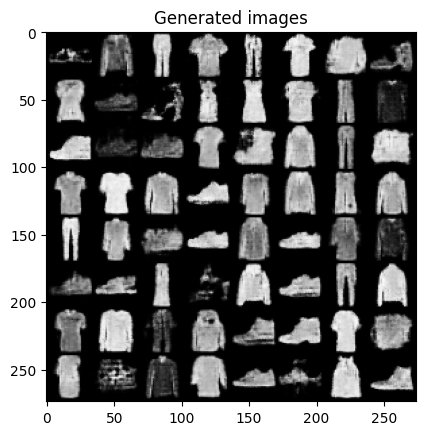

In [17]:
trainer.W_image_generation()

DCGAN training main

In [14]:
trainloader, _ = get_dataloaders(batch_size=64,trans='DCGAN')

generator = DCGAN_Generator(nc=1, nz=100, ngf=32).cuda()
discriminator = DCGAN_Discriminator(nc=1, ndf=32).cuda()

lr = 1e-4
betas = (0.9, 0.999)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
G_criterion=  torch.nn.BCELoss() #as described in the article
D_criterion= torch.nn.BCELoss() #as described in the article

G_DCGAN, D_DCGAN = train_DCGAN(discriminator, generator, D_criterion, G_criterion, D_optimizer, G_optimizer, trainloader, n_epoch=150, nz=100, use_gpu=True, print_every=100)

Output hidden; open in https://colab.research.google.com to view.

Plotting DCGAN images after training

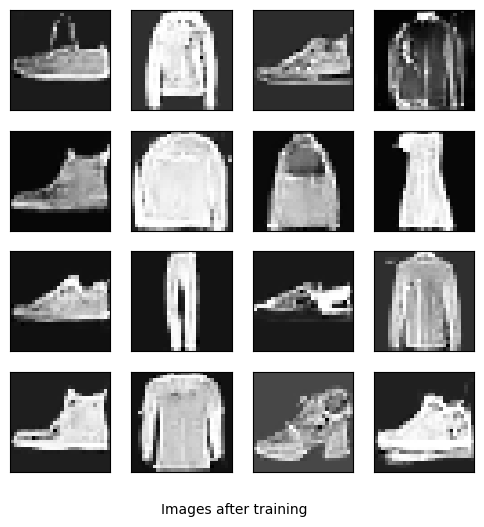

In [15]:
dc_image_generation(epoch=0, num_samples=16, generator_model=generator , use_gpu=True)

Plot examples from original Fashion Mnist for comparison

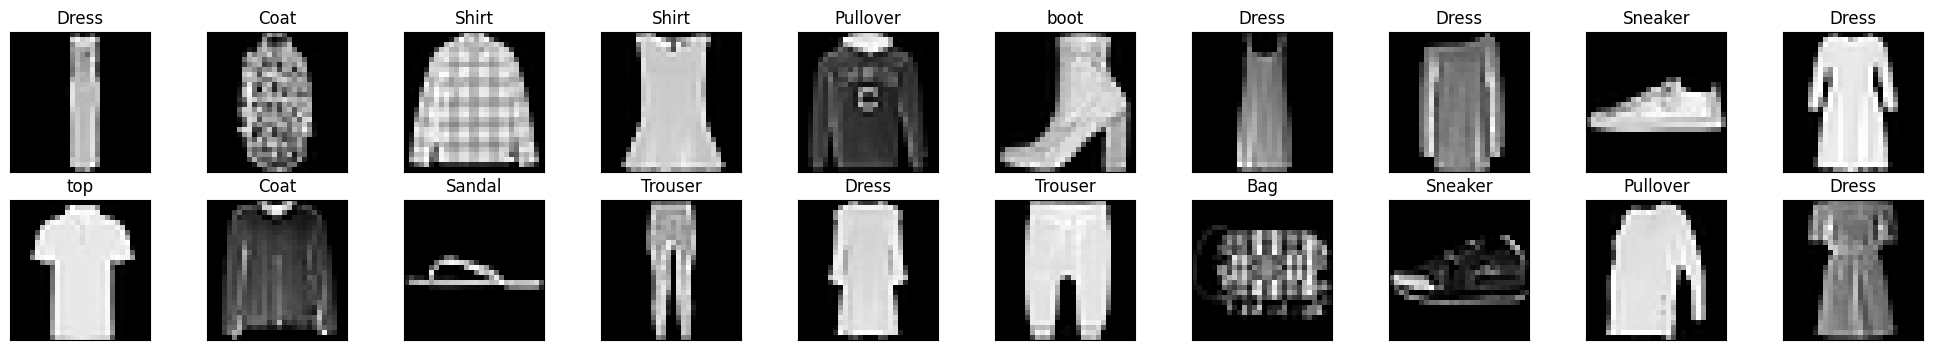

In [18]:
#visulaize data set
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

# specify the image classes
classes = ['top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'boot']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    class_index=labels[idx]
    ax.set_title(classes[class_index])

Loss plot

In [19]:
torch.save(D_WGAN,'D_WGAN.pt')
torch.save(D_DCGAN,'D_DCGAN.pt')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



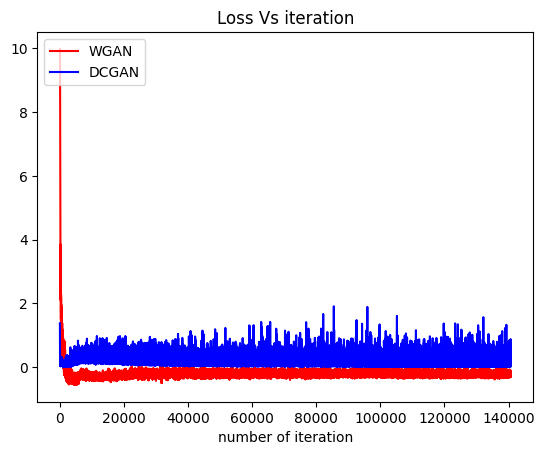

In [20]:

plt.plot(range(len(D_WGAN)), torch.tensor(D_WGAN).cpu(), '-r', label='WGAN')
print(D_WGAN)
print(D_DCGAN)
plt.plot(range(len(D_DCGAN)), torch.tensor(D_DCGAN).cpu(), '-b', label='DCGAN')

plt.xlabel("number of iteration")
plt.legend(loc='upper left')
plt.title('Loss Vs iteration')
plt.show()
